# **Deep Learning NB3: LSTMs (Along with CNNs)**

#### Final Model to be prioritized
MODEL 3 in the notebook

-------------
#### Overview
* LSTMs for text regression
* Split this data set into two sets - one for training our DL model, and one for evaluation  
* Use Keras to create an LSTM with multiple layers. We will train this model on CPU environments 
* Evaluate model performance by comparing training and validation scores

---
## Importing Libraries

In [9]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from multiprocessing import cpu_count
print(cpu_count())

16


In [10]:
%pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Note: you may need to restart the kernel to use updated packages.
Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [11]:
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Concatenate, BatchNormalization, Attention

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


from keras.models import load_model

from tensorflow.keras.datasets import imdb

from tensorflow.keras.utils import model_to_dot

In [12]:
from tensorflow.keras.optimizers import Adam

In [13]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

---
## Importing Data

In [15]:
df_proc=pd.read_csv('../00_gcp_data/preprocessed-essay.csv')
df_proc.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_tokenize_text,corrected_text,...,sent_count,sent_len,mistakes,num_mistakes,word_count,noun_count,verb_count,adjective_count,adverb_count,Score_Category
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students would benefit learning home won...,think students would benefit learning home won...,...,18,14.500000,NaN,0,261,61,25,25,5,medium
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...,problem change let best matter happening chang...,...,14,38.071429,NaN,0,533,100,56,37,9,medium
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal change school policy grade aver...,dear principal change school policy grade aver...,...,19,16.842105,NaN,0,320,58,20,33,5,medium
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...,best time life become agree greatest accomplis...,...,36,20.222222,NaN,0,728,106,73,62,22,high
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...,small act kindness impact people change people...,...,3,78.000000,kindess homeles triying greate kindess wount t...,11,234,58,21,18,5,medium


In [16]:
pd.options.display.max_colwidth=None
df_proc[['corrected_text','lemmatized_text']].sample(2)

,corrected_text,lemmatized_text
2759,anyone life shared wisdom experience ask someone important would love share maybe dad mon grandparents tones experience past person shared wisdom experience would father showed respectful adults show work business papers one thing father shared respect adults example father always best child would bad choices like going friends time listen parents got older realized one though serious rejected thought trouble child soon born able talk walk father would make say please thank well listening adults bow entering door greeting father want like younger made sure respectful grandparents shows father gave experience get respected family another thing father shared work business instance past months father showed paper work second job dad count money getting much give back workers times dad would come room teach split money making pay bills days showed showed much money everything made realized need work hard want simple job much gave job pay bills need work hard school shows father really cares future want well life showed wisdom hard like well school closing father taught business process one want business conclusion person showed wisdom experience would father teaching respect adult paper work job showed telling past show mange business older people important shared wisdom experience experience wisdom would share people people,anyone life share wisdom experience ask someone important would love share maybe dad mon grandparent tone experience past person share wisdom experience would father show respectful adult show work business paper one thing father share respect adult example father always best child would bad choice like go friend time listen parent get old realize one though serious reject thought trouble child soon born able talk walk father would make say please thank well listen adult bow enter door greet father want like young make sure respectful grandparent show father give experience get respect family another thing father share work business instance past month father show paper work second job dad count money get much give back worker time dad would come room teach split money make pay bill day show show much money everything make realize need work hard want simple job much give job pay bill need work hard school show father really care future want well life show wisdom hard like well school closing father taught business process one want business conclusion person show wisdom experience would father teach respect adult paper work job show tell past show mange business old people important share wisdom experience experience wisdom would share people people
192,dear principal honoured write letter pray take time busy schedule read letter hope good also want say happy student school first take stand decision changing school food healthier one say good one thoughtful idea also shows love school appreciate great idea good idea half student allergic reaction food chief cook rather hungry empty stomach incident still goes student might even pass one day secondly get healthier food active brains able function well soon class start however good breakfast even good food begin day sometimes help brain work well also help make brain good position working day work brain also consist contain particular minerals like carbohydrate protein fat supplementary substance also help human growth also help give energy human body lastly changing school food also make student never tried school lunch want try moreover student order food deliver school like school food allergic certain food incident keeps happening school food waste make school loose money therefore end speech saying good nice decision change school food healthier one once hope take time busy schedule read letter,dear principal honour write letter pray take time busy schedule read letter hope good also want say happy student school first take stand decision change school food healthier one say good one thoughtful idea also show love school 

In [17]:
## Setting text and target variables

textVar=df_proc['lemmatized_text']
targetVar=df_proc[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

----
## Setting Model Parameters

In [50]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our hidden layer
lstm_dims = 196

# Training parameters. Here we specify the training of the net will use 64 examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set 80 times
num_epochs = 10

# Prepossessing parameters
# We will input the first 1000 words of every essay (and pad out with nulls if a essay review is <1000 words
# We will also build our model using the most frequent 7000 words in our 'dictionary'

sequence_length = 1000
max_features = 7000

#Specify the number of variables to predic
num_classes = 6


-----
## Text Preprocessing

### Tokenize the data and pad sequences

In [19]:
X = textVar.values
Y = targetVar

train_samples, test_samples, train_targets, test_targets = train_test_split(X,Y, test_size = 0.20, random_state = 1010)

In [20]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_targets.shape)
print(test_samples.shape,test_targets.shape)

(3128,) (3128, 6)
(783,) (783, 6)


In [21]:
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

2023-05-24 05:02:25.445213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
vectorizer

### Convert our list of strings data to Numpy arrays of integer indices

In [24]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

Y_train = np.array(train_targets)
Y_test = np.array(test_targets)

In [25]:
X_train[:3]

array([[667,  81,  21, ...,   0,   0,   0],
       [ 16, 272,  10, ...,   0,   0,   0],
       [ 19, 285,   9, ...,   0,   0,   0]])

In [26]:
Y_train

array([[2.5, 2.5, 2.5, 2. , 2.5, 2. ],
       [2.5, 2. , 2. , 2.5, 2.5, 2.5],
       [3.5, 2.5, 3. , 3.5, 2.5, 2.5],
       ...,
       [3. , 3.5, 3.5, 3. , 3. , 3.5],
       [2.5, 2.5, 2.5, 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 2.5]])

### Load a pretrained vector space model - GLOVE

In [27]:
embeddings_index = {}

glove_dir = '../00_gcp_data/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [28]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6638 words (362 misses)


In [29]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79618001,  0.56779999, -0.96452999, ..., -0.28637001,
         0.54822999, -0.33597001],
       ...,
       [-0.01211   ,  0.001921  , -0.26157999, ...,  0.039627  ,
        -0.12142   , -0.44775   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Load the pre-trained word embeddings matrix into an Embedding layer
We will keep embeddings static with **trainable=False**

In [32]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

---
## MODEL 1: Baseline LSTM Model

In [73]:
sequence_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(lstm_dims, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="linear")(x)


model_lstm_1 = Model(sequence_input, preds)
model_lstm_1.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['mean_squared_error'])

model_lstm_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         700200    
                                                                 
 lstm_layer (LSTM)           (None, None, 196)         232848    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 196)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 196)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                9850      
                                                           

In [71]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

### Training the model

In [89]:
filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE

callbacks_list = [checkpoint]

t1 = time.time()
model_lstm_1_history = model_lstm_1.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks_list,
                    verbose=1)
t2 = time.time()
print("LSTM Glove model train time = %d seconds" %(t2-t1))

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.3609 - mean_squared_error: 0.3609
Epoch 1: val_mean_squared_error improved from inf to 0.34680, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 70s 2s/step - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3468 - val_mean_squared_error: 0.3468
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.3562 - mean_squared_error: 0.3562
Epoch 2: val_mean_squared_error improved from 0.34680 to 0.33910, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 74s 2s/step - loss: 0.3562 - mean_squared_error: 0.3562 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.3486 - mean_squared_error: 0.3486
Epoch 3: val_mean_squared_error improved from 0.33910 to 0.33868, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 89s 2s/step - loss: 0.3486 - mean_squared_error: 0.3486 - val_loss: 0.3387 - val_mean_squared_error: 0.3387
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 0.3368 - mean_squared_error: 0.3368
Epoch 4: val_mean_squared_error did not improve from 0.33868
40/40 [==============================] - 79s 2s/step - loss: 0.3368 - mean_squared_error: 0.3368 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 5/10
40/40 [==============================] - ETA: 0s - loss: 0.3570 - mean_squared_error: 0.3570
Epoch 5: val_mean_squared_error improved from 0.33868 to 0.33245, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 86s 2s/step - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 6/10
40/40 [==============================] - ETA: 0s - loss: 0.3524 - mean_squared_error: 0.3524
Epoch 6: val_mean_squared_error improved from 0.33245 to 0.33131, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 86s 2s/step - loss: 0.3524 - mean_squared_error: 0.3524 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 7/10
40/40 [==============================] - ETA: 0s - loss: 0.3222 - mean_squared_error: 0.3222
Epoch 7: val_mean_squared_error did not improve from 0.33131
40/40 [==============================] - 79s 2s/step - loss: 0.3222 - mean_squared_error: 0.3222 - val_loss: 0.3381 - val_mean_squared_error: 0.3381
Epoch 8/10
40/40 [==============================] - ETA: 0s - loss: 0.3249 - mean_squared_error: 0.3249
Epoch 8: val_mean_squared_error did not improve from 0.33131
40/40 [==============================] - 79s 2s/step - loss: 0.3249 - mean_squared_error: 0.3249 - val_loss: 0.3459 - val_mean_squared_error: 0.3459
Epoch 9/10
40/40 [==============================] - ETA: 0s - loss: 0.3223 - mean_squared_error: 0.3223
Epoch 9: val_mean_squared_error did not improve from 0.33131
40/40 [==============================] - 78s 2s/step - los

In [81]:
model_lstm_1_history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [85]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history    
    epochs = range(1, len(h['mean_squared_error']) + 1)
    plt.plot(epochs, h['mean_squared_error'], 'go', label='Training MSE')
    plt.plot(epochs, h['val_mean_squared_error'], 'g', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

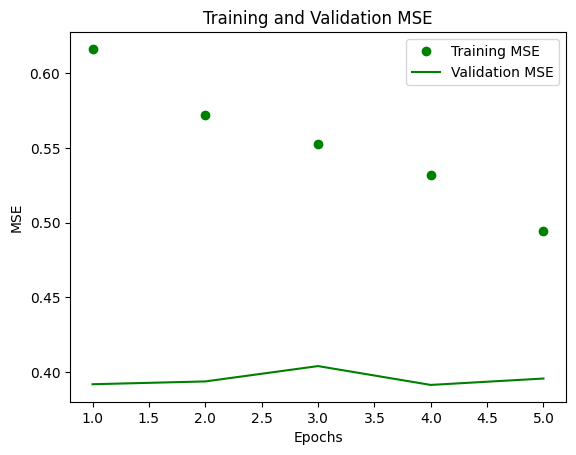

In [83]:
plot_train(model_lstm_1_history)

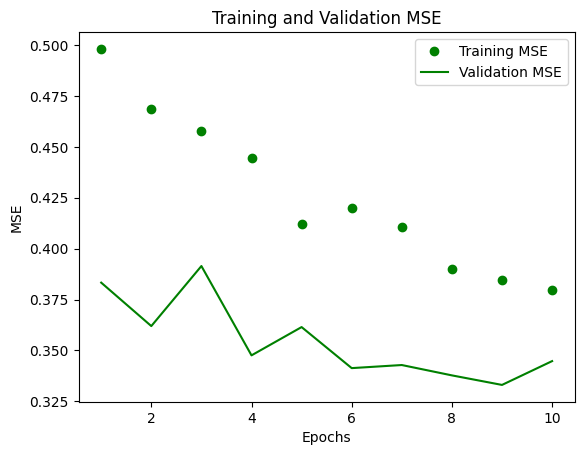

In [87]:
plot_train(model_lstm_1_history)

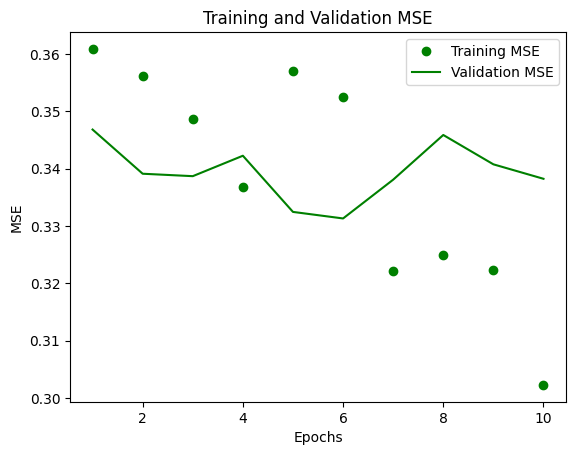

In [90]:
plot_train(model_lstm_1_history)

In [91]:
model_lstm_1.evaluate(X_test, Y_test)

25/25 [==============================] - 14s 562ms/step - loss: 0.3466 - mean_squared_error: 0.3466


[0.34658941626548767, 0.34658941626548767]

----
## MODEL 2: Combining LSTM and CNN

### Defining the custom loss function

In [35]:
def mcrmse(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

### New Architecture

In [67]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

def LSTM_CNN1D():
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
    
    input_1 = Input(shape=(sequence_length,),name = 'input_comment_1')
    embedding_layer_1 = embedding_layer(input_1)
    conv_1_1 = Convolution1D(64,3,strides=1, padding='same',activation='relu')(embedding_layer_1)
    lstm_1_1 = LSTM(64,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_1)
    concate_1 = keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_1])
    flatten_1 = Flatten()(concate_1)

    # creating further layers
    x = Dense(128, activation = 'relu')(flatten_1)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation = 'relu')(x)
    output = Dense(6,activation='linear')(x)
    
    model = Model(inputs = [input_1], outputs = [output])
    model.compile(optimizer=adam, loss = mcrmse, metrics = mcrmse)
    return model


In [68]:
mod_lstm_cnn=LSTM_CNN1D()
mod_lstm_cnn.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_comment_1 (InputLayer)   [(None, 1000)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1000, 100)    700200      ['input_comment_1[0][0]']        
                                                                                                  
 conv1d_11 (Conv1D)             (None, 1000, 64)     19264       ['embedding_6[0][0]']            
                                                                                                  
 lstm_11 (LSTM)                 (None, 1000, 64)     42240       ['embedding_6[0][0]']            
                                                                                            

In [70]:
filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mcrmse',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE
callbacks_list = [checkpoint]

mod_lstm_cnn_history = mod_lstm_cnn.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks_list,
                    verbose=1)


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 2.6080 - mcrmse: 2.5973
Epoch 1: val_mcrmse improved from inf to 4.50891, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 41s 949ms/step - loss: 2.6080 - mcrmse: 2.5973 - val_loss: 4.5122 - val_mcrmse: 4.5089
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 1.5764 - mcrmse: 1.5708
Epoch 2: val_mcrmse improved from 4.50891 to 4.26065, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 37s 927ms/step - loss: 1.5764 - mcrmse: 1.5708 - val_loss: 4.2671 - val_mcrmse: 4.2606
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.7363 - mcrmse: 0.7377
Epoch 3: val_mcrmse improved from 4.26065 to 2.28773, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 37s 937ms/step - loss: 0.7363 - mcrmse: 0.7377 - val_loss: 2.2911 - val_mcrmse: 2.2877
Epoch 4/20
40/40 [==============================] - ETA: 0s - loss: 0.5910 - mcrmse: 0.5913
Epoch 4: val_mcrmse improved from 2.28773 to 0.92373, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 37s 934ms/step - loss: 0.5910 - mcrmse: 0.5913 - val_loss: 0.9252 - val_mcrmse: 0.9237
Epoch 5/20
40/40 [==============================] - ETA: 0s - loss: 0.5114 - mcrmse: 0.5139
Epoch 5: val_mcrmse improved from 0.92373 to 0.66642, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 36s 913ms/step - loss: 0.5114 - mcrmse: 0.5139 - val_loss: 0.6679 - val_mcrmse: 0.6664
Epoch 6/20
40/40 [==============================] - ETA: 0s - loss: 0.4891 - mcrmse: 0.4877
Epoch 6: val_mcrmse did not improve from 0.66642
40/40 [==============================] - 26s 660ms/step - loss: 0.4891 - mcrmse: 0.4877 - val_loss: 0.7047 - val_mcrmse: 0.7042
Epoch 7/20
40/40 [==============================] - ETA: 0s - loss: 0.4388 - mcrmse: 0.4445
Epoch 7: val_mcrmse improved from 0.66642 to 0.64633, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 37s 936ms/step - loss: 0.4388 - mcrmse: 0.4445 - val_loss: 0.6476 - val_mcrmse: 0.6463
Epoch 8/20
40/40 [==============================] - ETA: 0s - loss: 0.4193 - mcrmse: 0.4231
Epoch 8: val_mcrmse did not improve from 0.64633
40/40 [==============================] - 26s 664ms/step - loss: 0.4193 - mcrmse: 0.4231 - val_loss: 0.6684 - val_mcrmse: 0.6673
Epoch 9/20
40/40 [==============================] - ETA: 0s - loss: 0.3924 - mcrmse: 0.3991
Epoch 9: val_mcrmse did not improve from 0.64633
40/40 [==============================] - 26s 654ms/step - loss: 0.3924 - mcrmse: 0.3991 - val_loss: 1.1979 - val_mcrmse: 1.1989
Epoch 10/20
40/40 [==============================] - ETA: 0s - loss: 0.3808 - mcrmse: 0.3938
Epoch 10: val_mcrmse did not improve from 0.64633
40/40 [==============================] - 26s 664ms/step - loss: 0.3808 - mcrmse: 0.3938 - val_loss: 0.7346 - val_mcrmse: 0.7339
Epoch 11/20
40/40 [==============================] - ETA: 0s - 

In [47]:
mod_lstm_cnn_history.history.keys()

dict_keys(['loss', 'mcrmse', 'val_loss', 'val_mcrmse'])

In [33]:
def plot_train_rmse(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['mcrmse']) + 1)
    plt.subplots(1,1,figsize=(13,8))
    plt.plot(epochs, h['mcrmse'], 'r', label='Training RMSE')
    plt.plot(epochs, h['val_mcrmse'], 'g', label='Validation RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

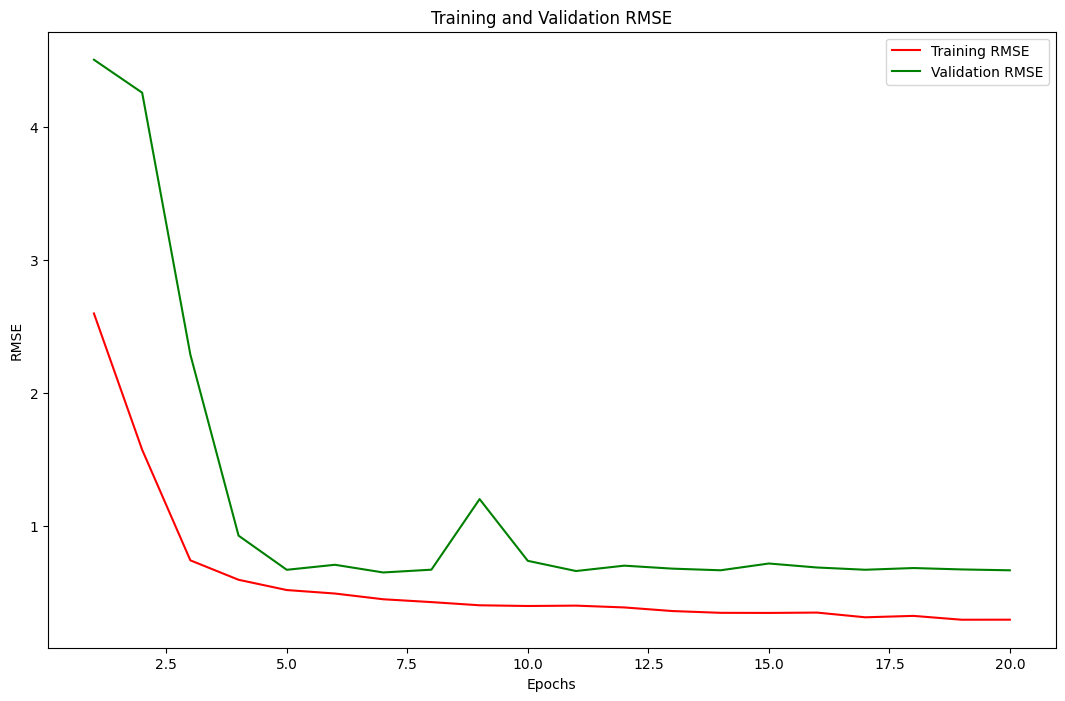

In [80]:
plot_train_rmse(mod_lstm_cnn_history)

In [82]:
mod_lstm_cnn.evaluate(X_test,Y_test)

25/25 [==============================] - 5s 194ms/step - loss: 0.6618 - mcrmse: 0.6610


[0.6617537140846252, 0.6609731912612915]

### Adding more callbacks to alter learning rates and add early stopping

In [84]:
from tensorflow.keras.callbacks import *
import os
reduce_lr = ReduceLROnPlateau(monitor = 'val_mcrmse', factor = 0.25, patience = 2, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_mcrmse',  mode="min", min_delta = 0, patience = 25,verbose = 1)
# filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best"
# checkpoint = ModelCheckpoint(filepath, monitor='val_mcrmse',
#                              verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

callbacks = [reduce_lr,earlystop]


In [100]:
# re-instantiating the model

def LSTM_CNN1D_2():
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
    
    input_1 = Input(shape=(sequence_length,))
    embedding_layer_1 = embedding_layer(input_1)
    conv_1_1 = Convolution1D(64,3,strides=1, padding='same',activation='relu')(embedding_layer_1)
    lstm_1_1 = LSTM(64,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_1)
    concate_1 = keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_1])
    flatten_1 = Flatten()(concate_1)

    # creating further layers
    x = Dense(128, activation = 'relu')(flatten_1)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation = 'relu')(x)
    output = Dense(6,activation='linear')(x)
    
    model = Model(inputs = [input_1], outputs = [output])
    optimizer=Adam()
    model.compile(optimizer=optimizer, loss = mcrmse, metrics = mcrmse)
    return model

In [101]:
mod_lstm_cnn2=LSTM_CNN1D_2()
mod_lstm_cnn2.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1000, 100)    700200      ['input_7[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 1000, 64)     19264       ['embedding_6[9][0]']            
                                                                                                  
 lstm_20 (LSTM)                 (None, 1000, 64)     42240       ['embedding_6[9][0]']            
                                                                                           

In [102]:
num_epochs=20
mod_lstm_cnn2_history = mod_lstm_cnn2.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/20
40/40 [==============================] - 26s 573ms/step - loss: 2.2156 - mcrmse: 2.2041 - val_loss: 2.4383 - val_mcrmse: 2.4344 - lr: 0.0010
Epoch 2/20
40/40 [==============================] - 22s 561ms/step - loss: 1.2537 - mcrmse: 1.2567 - val_loss: 2.7496 - val_mcrmse: 2.7459 - lr: 0.0010
Epoch 3/20
40/40 [==============================] - 22s 563ms/step - loss: 0.7747 - mcrmse: 0.7745 - val_loss: 1.0598 - val_mcrmse: 1.0571 - lr: 0.0010
Epoch 4/20
40/40 [==============================] - 22s 561ms/step - loss: 0.5594 - mcrmse: 0.5625 - val_loss: 0.7864 - val_mcrmse: 0.7853 - lr: 0.0010
Epoch 5/20
40/40 [==============================] - 22s 555ms/step - loss: 0.4906 - mcrmse: 0.4959 - val_loss: 0.6979 - val_mcrmse: 0.6958 - lr: 0.0010
Epoch 6/20
40/40 [==============================] - 22s 561ms/step - loss: 0.4628 - mcrmse: 0.4782 - val_loss: 0.7090 - val_mcrmse: 0.7080 - lr: 0.0010
Epoch 7/20
40/40 [==============================] - 22s 560ms/step - loss: 0.4138 - mcrm

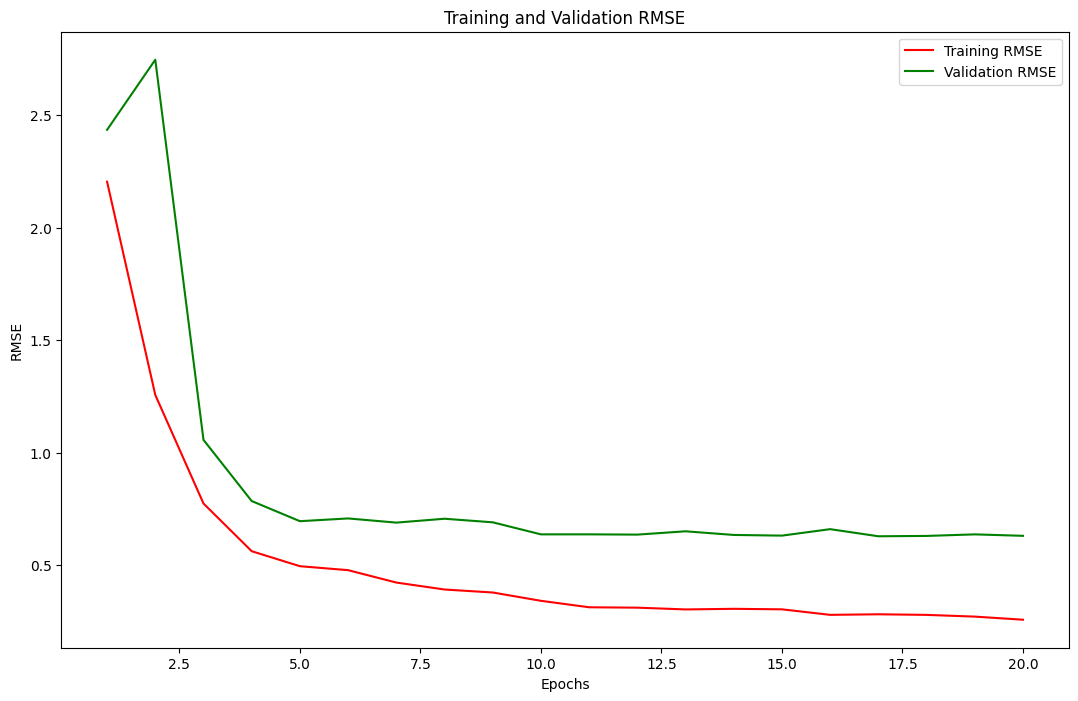

In [103]:
plot_train_rmse(mod_lstm_cnn2_history)

In [104]:
mod_lstm_cnn2.evaluate(X_test,Y_test)

25/25 [==============================] - 3s 117ms/step - loss: 0.6417 - mcrmse: 0.6402


[0.6417043209075928, 0.6402416229248047]

----
## MODEL 3: Pushing the text through another Conv1D + LSTM layer

In [36]:
def LSTM_CNN1D_3():
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
    
    input_1 = Input(shape=(sequence_length,))
    embedding_layer_1 = embedding_layer(input_1)
    conv_1_1 = Convolution1D(64,3,strides=1, padding='same',activation='relu')(embedding_layer_1)
    lstm_1_1 = LSTM(64,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_1)
    concate_1 = keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_1])
    flatten_1 = Flatten()(concate_1)

    input_2 = Input(shape=(sequence_length,))
    embedding_layer_2 = embedding_layer(input_2)
    conv_1_1 = Convolution1D(128,3,strides=1, padding='same',activation='relu')(embedding_layer_2)
    lstm_1_2 = LSTM(128,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_2)
    concate_2 = keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_2])
    flatten_2 = Flatten()(concate_2)

    concatenated_layer = keras.layers.concatenate([flatten_1,flatten_2],axis=-1)

    # creating further layers
    x = Dense(128, activation = 'relu')(concatenated_layer)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation = 'relu')(x)
    output = Dense(6,activation='linear')(x)
    
    model = Model(inputs = [input_1,input_2], outputs = [output])
    optimizer=Adam()
    model.compile(optimizer=optimizer, loss = mcrmse, metrics = mcrmse)
    return model

In [37]:
mod_lstm_cnn3=LSTM_CNN1D_3()
mod_lstm_cnn3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 100)    700200      ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1000, 64)     19264       ['embedding[2][0]']        

In [49]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
svg_image=SVG(model_to_dot(mod_lstm_cnn3, show_shapes=True, dpi=150).create(prog='dot', format='svg'))
with open("model_plot.svg", "w") as f:
    f.write(svg_image.data)

In [29]:
from tensorflow.keras.callbacks import *
import os
reduce_lr = ReduceLROnPlateau(monitor = 'val_mcrmse', factor = 0.25, patience = 2, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_mcrmse',  mode="min", min_delta = 0, patience = 25,verbose = 1)
filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mcrmse',verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

callbacks = [reduce_lr,earlystop,checkpoint]

In [30]:
X_train_3=[vectorizer(np.array([[s] for s in train_samples])).numpy(),vectorizer(np.array([[s] for s in train_samples])).numpy()]

In [31]:
num_epochs=30
mod_lstm_cnn3_history = mod_lstm_cnn3.fit(X_train_3, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 2.6367 - mcrmse: 2.6237
Epoch 1: val_mcrmse improved from inf to 2.18057, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 78s 2s/step - loss: 2.6367 - mcrmse: 2.6237 - val_loss: 2.1811 - val_mcrmse: 2.1806 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 1.6090 - mcrmse: 1.6003
Epoch 2: val_mcrmse improved from 2.18057 to 1.83266, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 70s 2s/step - loss: 1.6090 - mcrmse: 1.6003 - val_loss: 1.8378 - val_mcrmse: 1.8327 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 0.9226 - mcrmse: 0.9279
Epoch 3: val_mcrmse improved from 1.83266 to 1.49585, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 70s 2s/step - loss: 0.9226 - mcrmse: 0.9279 - val_loss: 1.4981 - val_mcrmse: 1.4958 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 0.7191 - mcrmse: 0.7339
Epoch 4: val_mcrmse improved from 1.49585 to 1.03416, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 70s 2s/step - loss: 0.7191 - mcrmse: 0.7339 - val_loss: 1.0353 - val_mcrmse: 1.0342 - lr: 0.0010
Epoch 5/30
40/40 [==============================] - ETA: 0s - loss: 0.6444 - mcrmse: 0.6502
Epoch 5: val_mcrmse improved from 1.03416 to 0.90630, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 73s 2s/step - loss: 0.6444 - mcrmse: 0.6502 - val_loss: 0.9062 - val_mcrmse: 0.9063 - lr: 0.0010
Epoch 6/30
40/40 [==============================] - ETA: 0s - loss: 0.6007 - mcrmse: 0.6124
Epoch 6: val_mcrmse did not improve from 0.90630
40/40 [==============================] - 53s 1s/step - loss: 0.6007 - mcrmse: 0.6124 - val_loss: 0.9859 - val_mcrmse: 0.9868 - lr: 0.0010
Epoch 7/30
40/40 [==============================] - ETA: 0s - loss: 0.5283 - mcrmse: 0.5372
Epoch 7: val_mcrmse improved from 0.90630 to 0.74060, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 73s 2s/step - loss: 0.5283 - mcrmse: 0.5372 - val_loss: 0.7401 - val_mcrmse: 0.7406 - lr: 0.0010
Epoch 8/30
40/40 [==============================] - ETA: 0s - loss: 0.4779 - mcrmse: 0.4797
Epoch 8: val_mcrmse improved from 0.74060 to 0.73054, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 95s 2s/step - loss: 0.4779 - mcrmse: 0.4797 - val_loss: 0.7308 - val_mcrmse: 0.7305 - lr: 0.0010
Epoch 9/30
40/40 [==============================] - ETA: 0s - loss: 0.4476 - mcrmse: 0.4547
Epoch 9: val_mcrmse did not improve from 0.73054
40/40 [==============================] - 69s 2s/step - loss: 0.4476 - mcrmse: 0.4547 - val_loss: 0.7733 - val_mcrmse: 0.7736 - lr: 0.0010
Epoch 10/30
40/40 [==============================] - ETA: 0s - loss: 0.4408 - mcrmse: 0.4447
Epoch 10: val_mcrmse improved from 0.73054 to 0.67897, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 96s 2s/step - loss: 0.4408 - mcrmse: 0.4447 - val_loss: 0.6795 - val_mcrmse: 0.6790 - lr: 0.0010
Epoch 11/30
40/40 [==============================] - ETA: 0s - loss: 0.4210 - mcrmse: 0.4229
Epoch 11: val_mcrmse did not improve from 0.67897
40/40 [==============================] - 69s 2s/step - loss: 0.4210 - mcrmse: 0.4229 - val_loss: 0.6934 - val_mcrmse: 0.6924 - lr: 0.0010
Epoch 12/30
40/40 [==============================] - ETA: 0s - loss: 0.3806 - mcrmse: 0.3855
Epoch 12: val_mcrmse improved from 0.67897 to 0.66325, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 93s 2s/step - loss: 0.3806 - mcrmse: 0.3855 - val_loss: 0.6642 - val_mcrmse: 0.6632 - lr: 0.0010
Epoch 13/30
40/40 [==============================] - ETA: 0s - loss: 0.3794 - mcrmse: 0.4007
Epoch 13: val_mcrmse improved from 0.66325 to 0.65710, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 93s 2s/step - loss: 0.3794 - mcrmse: 0.4007 - val_loss: 0.6569 - val_mcrmse: 0.6571 - lr: 0.0010
Epoch 14/30
40/40 [==============================] - ETA: 0s - loss: 0.3486 - mcrmse: 0.3659
Epoch 14: val_mcrmse did not improve from 0.65710
40/40 [==============================] - 69s 2s/step - loss: 0.3486 - mcrmse: 0.3659 - val_loss: 0.6802 - val_mcrmse: 0.6809 - lr: 0.0010
Epoch 15/30
40/40 [==============================] - ETA: 0s - loss: 0.3689 - mcrmse: 0.3744
Epoch 15: val_mcrmse improved from 0.65710 to 0.64199, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 94s 2s/step - loss: 0.3689 - mcrmse: 0.3744 - val_loss: 0.6420 - val_mcrmse: 0.6420 - lr: 0.0010
Epoch 16/30
40/40 [==============================] - ETA: 0s - loss: 0.3388 - mcrmse: 0.3462
Epoch 16: val_mcrmse did not improve from 0.64199
40/40 [==============================] - 68s 2s/step - loss: 0.3388 - mcrmse: 0.3462 - val_loss: 0.6558 - val_mcrmse: 0.6557 - lr: 0.0010
Epoch 17/30
40/40 [==============================] - ETA: 0s - loss: 0.3424 - mcrmse: 0.3461
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_mcrmse did not improve from 0.64199
40/40 [==============================] - 76s 2s/step - loss: 0.3424 - mcrmse: 0.3461 - val_loss: 0.6458 - val_mcrmse: 0.6450 - lr: 0.0010
Epoch 18/30
40/40 [==============================] - ETA: 0s - loss: 0.3087 - mcrmse: 0.3147
Epoch 18: val_mcrmse improved from 0.64199 to 0.62828, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/c

INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 110s 3s/step - loss: 0.3087 - mcrmse: 0.3147 - val_loss: 0.6290 - val_mcrmse: 0.6283 - lr: 2.5000e-04
Epoch 19/30
40/40 [==============================] - ETA: 0s - loss: 0.3078 - mcrmse: 0.3293
Epoch 19: val_mcrmse improved from 0.62828 to 0.62563, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 100s 3s/step - loss: 0.3078 - mcrmse: 0.3293 - val_loss: 0.6264 - val_mcrmse: 0.6256 - lr: 2.5000e-04
Epoch 20/30
40/40 [==============================] - ETA: 0s - loss: 0.2917 - mcrmse: 0.3034
Epoch 20: val_mcrmse improved from 0.62563 to 0.62460, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 84s 2s/step - loss: 0.2917 - mcrmse: 0.3034 - val_loss: 0.6257 - val_mcrmse: 0.6246 - lr: 2.5000e-04
Epoch 21/30
40/40 [==============================] - ETA: 0s - loss: 0.2744 - mcrmse: 0.2803
Epoch 21: val_mcrmse improved from 0.62460 to 0.62294, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 81s 2s/step - loss: 0.2744 - mcrmse: 0.2803 - val_loss: 0.6241 - val_mcrmse: 0.6229 - lr: 2.5000e-04
Epoch 22/30
40/40 [==============================] - ETA: 0s - loss: 0.2677 - mcrmse: 0.2756
Epoch 22: val_mcrmse did not improve from 0.62294
40/40 [==============================] - 57s 1s/step - loss: 0.2677 - mcrmse: 0.2756 - val_loss: 0.6293 - val_mcrmse: 0.6286 - lr: 2.5000e-04
Epoch 23/30
40/40 [==============================] - ETA: 0s - loss: 0.2709 - mcrmse: 0.2893
Epoch 23: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 23: val_mcrmse did not improve from 0.62294
40/40 [==============================] - 57s 1s/step - loss: 0.2709 - mcrmse: 0.2893 - val_loss: 0.6247 - val_mcrmse: 0.6242 - lr: 2.5000e-04
Epoch 24/30
40/40 [==============================] - ETA: 0s - loss: 0.2649 - mcrmse: 0.2732
Epoch 24: val_mcrmse improved from 0.62294 to 0.62159, saving model to /home/jupyter/automatic-essay-grading-DL/05_Mod

INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/cnn_lstm_glove_weights_best/assets


40/40 [==============================] - 76s 2s/step - loss: 0.2649 - mcrmse: 0.2732 - val_loss: 0.6226 - val_mcrmse: 0.6216 - lr: 6.2500e-05
Epoch 25/30
40/40 [==============================] - ETA: 0s - loss: 0.2524 - mcrmse: 0.2646
Epoch 25: val_mcrmse did not improve from 0.62159
40/40 [==============================] - 56s 1s/step - loss: 0.2524 - mcrmse: 0.2646 - val_loss: 0.6233 - val_mcrmse: 0.6226 - lr: 6.2500e-05
Epoch 26/30
40/40 [==============================] - ETA: 0s - loss: 0.2502 - mcrmse: 0.2770
Epoch 26: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 26: val_mcrmse did not improve from 0.62159
40/40 [==============================] - 56s 1s/step - loss: 0.2502 - mcrmse: 0.2770 - val_loss: 0.6236 - val_mcrmse: 0.6230 - lr: 6.2500e-05
Epoch 27/30
40/40 [==============================] - ETA: 0s - loss: 0.2538 - mcrmse: 0.2582
Epoch 27: val_mcrmse did not improve from 0.62159
40/40 [==============================] - 56s 1s/step - loss: 0.253

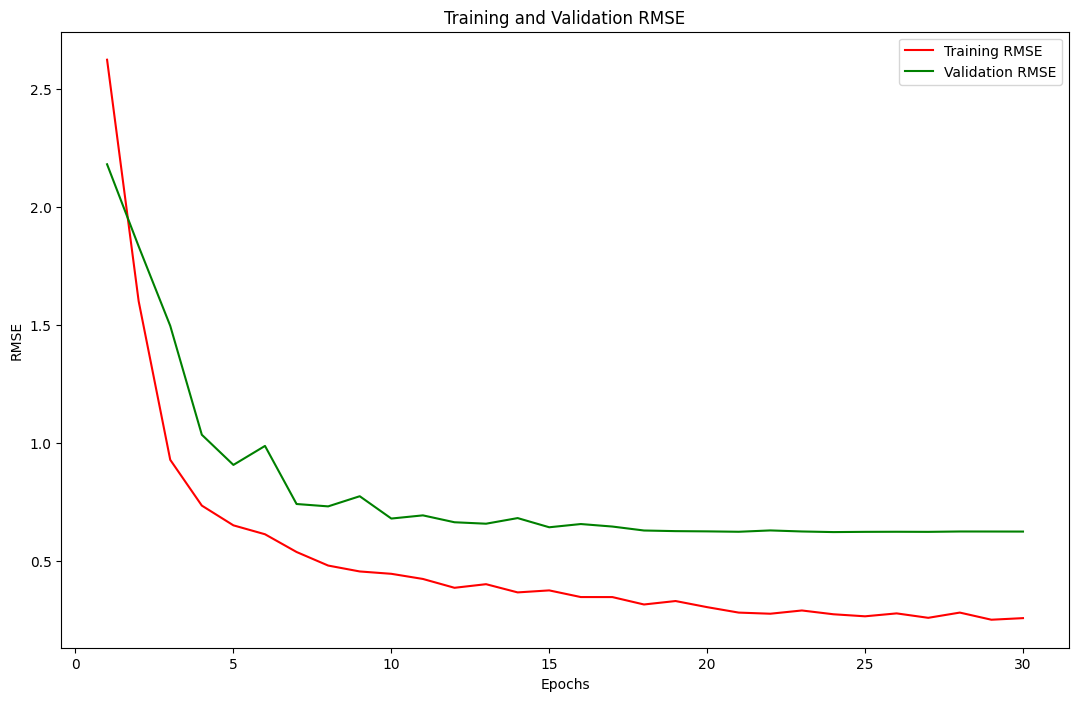

In [34]:
plot_train_rmse(mod_lstm_cnn3_history)

In [36]:
X_test_3=[vectorizer(np.array([[s] for s in test_samples])).numpy(),vectorizer(np.array([[s] for s in test_samples])).numpy()]
mod_lstm_cnn3.evaluate(X_test_3,Y_test)

25/25 [==============================] - 9s 350ms/step - loss: 0.6234 - mcrmse: 0.6224


[0.6234258413314819, 0.6224086284637451]

In [37]:
mod_lstm_cnn3.save('mod_lstm_cnn3.h5')

In [ ]:
def plot_train_rmse(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['mcrmse']) + 1)
    plt.subplots(1,1,figsize=(13,8))
    plt.plot(epochs, h['mcrmse'], 'r', label='Training RMSE')
    plt.plot(epochs, h['val_mcrmse'], 'g', label='Validation RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

In [51]:
def save_epochs(history):
    h = history.history
    df = pd.DataFrame({'Epochs':list(range(1, len(h['mcrmse']) + 1)), 'RMSE':list(h['mcrmse'])})
    return df


In [46]:
mod_lstm_cnn3_epochs_df=save_epochs(mod_lstm_cnn3_history)
mod_lstm_cnn3_epochs_df.to_csv('mod_lstm_cnn3_epochs_df.csv', index=False)